# Introduction
A personal analysis on UFC athlete fighting statistics. There are 118 columns of valuable information that can be used to visualize a fighter's strength or weakness. This analysis has a primary focus on extracting fighter finishes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "ufc-master.csv"
df = pd.read_csv(path)

In [3]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (6528, 118)


# Data Preproccesing
There are 118 columns and 6528 rows. The ranking columns contain sparse data since it includes all weight-classes in columns. Rankings are an irrelevant feature for fighter's ability to finish.


In [4]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_data = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_data)

BWFeatherweightRank      99.984681
RWFeatherweightRank      99.862132
BPFPRank                 98.973652
BWFlyweightRank          98.881740
RWFlyweightRank          98.529412
BWStrawweightRank        98.468137
BWBantamweightRank       98.360907
BWelterweightRank        98.177083
BBantamweightRank        98.177083
BLightHeavyweightRank    98.161765
BLightweightRank         98.161765
BFeatherweightRank       98.100490
BFlyweightRank           98.008578
BMiddleweightRank        97.901348
RWStrawweightRank        97.763480
BHeavyweightRank         97.732843
RWBantamweightRank       97.640931
RFeatherweightRank       97.288603
RBantamweightRank        97.227328
RMiddleweightRank        97.212010
RLightHeavyweightRank    97.181373
RLightweightRank         97.181373
RHeavyweightRank         97.150735
RFlyweightRank           97.120098
RWelterweightRank        97.074142
RPFPRank                 96.124387
BMatchWCRank             81.617647
RMatchWCRank             72.748162
FinishDetails       

In [5]:
# Remove columns with missing values > 60%
threshold = 0.6
missing_ratio = df.isnull().mean()
cols_to_keep = missing_ratio[missing_ratio < threshold].index
df = df[cols_to_keep].copy()
print(f"Columns after dropping > {threshold*100:.0f}% missing: {df.shape[1]}")


Columns after dropping > 60% missing: 90


In [6]:
# Basic type cleanup and categorical ordering
# Convert the event date into a numeric year for modeling
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.year

# Normalize spelling/casing for categorical values
df["WeightClass"] = df["WeightClass"].str.replace("Women's ", "", regex=False)
df["Gender"] = df["Gender"].str.capitalize()

# Reorder weight index
weight_class_order = ['Flyweight',
             'Bantamweight',
             'Featherweight',
             'Lightweight',
             'Welterweight',
             'Middleweight',
             'Light Heavyweight',
             'Heavyweight',
             "Women's Strawweight",
             "Women's Flyweight",
             "Women's Bantamweight",
             "Women's Featherweight",
             'Catch Weight']
df["WeightClass"] = pd.Categorical(df["WeightClass"], categories=weight_class_order, ordered=True)

#Drop Catch Weight (UFC no longer supports this weight class)
df = df[df["WeightClass"] != "Catch Weight"].copy()

# Trim stray whitespace and convert numeric-looking columns
for col in df.columns:
    if df[col].dtype == object and col != "WeightClass":
        df[col] = df[col].str.strip()

df = df.convert_dtypes()

In [7]:
# Drop clearly irrelevant columns
columns_to_drop = [
    "RedFighter", "BlueFighter",
    # Can be derived
    "RedExpectedValue", "BlueExpectedValue",
    # Location
    "Location", "Country",
    # Other
    "EmptyArena", "RedDraws", "BlueDraws", "FinishRoundTime"
]
existing_cols_to_drop = [c for c in columns_to_drop if c in df.columns]
df = df.drop(columns=existing_cols_to_drop)
print(f"Columns after dropping: {df.shape[1]}")

Columns after dropping: 80


In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb


X = df.drop(['Winner', 'Finish'], axis=1)
y = df['Winner'].map({'Red' : 1, 'Blue' : 0})

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.001,
    nthread=8
)

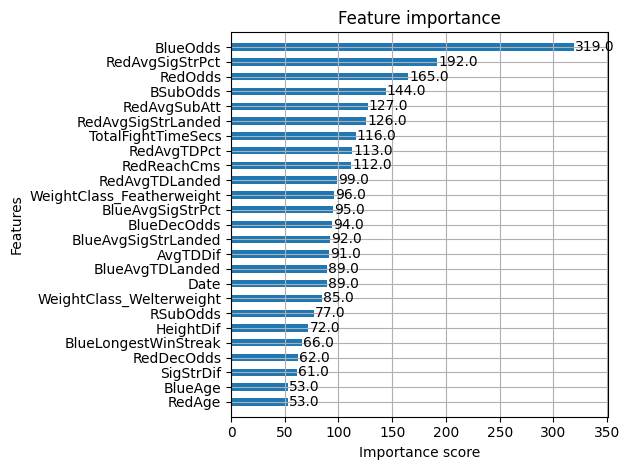

In [9]:
model.fit(X_train, y_train)

importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
      'Feature': X.columns,
      'Importance': importance
}).sort_values('Importance', ascending=False)

from xgboost import plot_importance
xgb.plot_importance(model, max_num_features=25, height=0.5)
plt.tight_layout()
plt.show()

## Hypothesis:
## Are betting market odds more accurate predictors of UFC fight outcomes than fighter statistics, physical attributes, and official rankings?

# Model Development and Experimentation

In [10]:
betting_features = [
      'RedOdds',
      'BlueOdds',
      'BetterRank',
      'RedDecOdds',
      'BlueDecOdds',
      'RSubOdds',
      'BSubOdds',
      'RKOOdds',
      'BKOOdds'
]

fighter_stats = [
      'RedAvgSigStrLanded',
      'BlueAvgSigStrLanded',
      'RedAvgSigStrPct',
      'BlueAvgSigStrPct',
      'RedAvgTDLanded',
      'BlueAvgTDLanded',
      'RedAvgTDPct',
      'BlueAvgTDPct',
      'RedAvgSubAtt',
      'BlueAvgSubAtt',
      'RedWins',
      'BlueWins',
      'RedLosses',
      'BlueLosses',
      'RedCurrentWinStreak',
      'BlueCurrentWinStreak',
      'RedCurrentLoseStreak',
      'BlueCurrentLoseStreak',
      'RedWinsByKO',
      'BlueWinsByKO',
      'RedWinsBySubmission',
      'BlueWinsBySubmission',
      'RedTotalRoundsFought',
      'BlueTotalRoundsFought',
      'SigStrDif',
      'AvgTDDif',
      'AvgSubAttDif',
      'WinDif',
      'LossDif',
      'WinStreakDif',
      'KODif',
      'SubDif'
]

physical_features = [
      'RedHeightCms',
      'BlueHeightCms',
      'RedReachCms',
      'BlueReachCms',
      'RedAge',
      'BlueAge',
      'HeightDif',
      'ReachDif',
      'AgeDif',
      'RedStance',
      'BlueStance'
]

all_features = betting_features + fighter_stats + physical_features

df = df.dropna(subset=all_features)

X_betting = df[betting_features]
X_stats = df[fighter_stats]
X_physical = df[physical_features]


X_all = df[all_features]

y = df['Winner'].map({'Red': 1, 'Blue': 0})

## Classification - Core Analysis

In [15]:
# Supervised Learning (Classification) - loop over feature sets (simple encoding)
# Compare betting odds vs fighter stats vs physical vs all features without per-loop pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_sets = {
    "betting": X_betting,
    "fighter_stats": X_stats,
    "physical": X_physical,
    "all": X_all,
}

rows = []
roc_data = {}  # Store ROC curve data for visualization

for name, X_subset in feature_sets.items():
    # Combine features with target and drop missing targets once
    data = X_subset.copy()
    data["target"] = y
    data = data.dropna(subset=["target"])
    y_sub = data.pop("target").astype(int)

    # One-hot encode categoricals; simple numeric fill for any remaining NAs
    X_encoded = pd.get_dummies(data, drop_first=True)
    X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))

    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_sub, test_size=0.2, random_state=42, stratify=y_sub
    )
    
    # Scale features for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Logistic Regression on scaled data
    log_reg = LogisticRegression(
        max_iter=1000,
        C=1.0,
        random_state=42
    )
    log_reg.fit(X_train_scaled, y_train)
    log_preds = log_reg.predict(X_test_scaled)
    log_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
    rows.append({
        "feature_set": name,
        "model": "log_reg",
        "accuracy": accuracy_score(y_test, log_preds),
        "f1": f1_score(y_test, log_preds),
        "roc_auc": roc_auc_score(y_test, log_proba),
    })

    # Random Forest nonlinear baseline
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_proba = rf.predict_proba(X_test)[:, 1]
    rows.append({
        "feature_set": name,
        "model": "random_forest",
        "accuracy": accuracy_score(y_test, rf_preds),
        "f1": f1_score(y_test, rf_preds),
        "roc_auc": roc_auc_score(y_test, rf_proba),
    })
    
    # XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
    rows.append({
        "feature_set": name,
        "model": "xgboost",
        "accuracy": accuracy_score(y_test, xgb_preds),
        "f1": f1_score(y_test, xgb_preds),
        "roc_auc": roc_auc_score(y_test, xgb_proba),
    })
    
    # Store ROC curve data for XGBoost (best model)
    fpr, tpr, _ = roc_curve(y_test, xgb_proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc_score(y_test, xgb_proba)}

results_df = pd.DataFrame(rows).sort_values(["feature_set", "roc_auc"], ascending=[True, False])
print(results_df)

# Summary Statistics
print("\n" + "="*60)
print("KEY FINDINGS:")
print("="*60)
best_overall = results_df.loc[results_df['roc_auc'].idxmax()]
print(f"✓ Best overall performance: {best_overall['model']} with {best_overall['feature_set']} features")
print(f"  ROC-AUC: {best_overall['roc_auc']:.3f}, Accuracy: {best_overall['accuracy']:.3f}")

betting_best = results_df[results_df['feature_set'] == 'betting']['roc_auc'].max()
stats_best = results_df[results_df['feature_set'] == 'fighter_stats']['roc_auc'].max()
all_best = results_df[results_df['feature_set'] == 'all']['roc_auc'].max()

print(f"\n✓ Betting odds alone: {betting_best:.3f} ROC-AUC")
print(f"✓ Fighter stats alone: {stats_best:.3f} ROC-AUC")
print(f"✓ All features combined: {all_best:.3f} ROC-AUC")
print(f"\n→ Improvement from adding stats to odds: {(all_best - betting_best):.3f} ({((all_best - betting_best)/betting_best)*100:.1f}%)")
print(f"→ Betting odds outperform fighter stats by: {(betting_best - stats_best):.3f}")

      feature_set          model  accuracy        f1   roc_auc
10            all  random_forest  0.643852  0.711195  0.703352
9             all        log_reg  0.655452  0.714697  0.696969
11            all        xgboost  0.650812  0.711409  0.691011
0         betting        log_reg  0.649652  0.712381  0.706182
1         betting  random_forest  0.646172  0.717854  0.697273
2         betting        xgboost  0.647332  0.703704  0.674633
4   fighter_stats  random_forest  0.599768  0.720195  0.625436
3   fighter_stats        log_reg  0.605568  0.705882  0.613112
5   fighter_stats        xgboost  0.587007  0.675774  0.605322
6        physical        log_reg  0.570766  0.676007  0.589562
7        physical  random_forest  0.597448  0.716735  0.584172
8        physical        xgboost  0.580046  0.667890  0.575025

KEY FINDINGS:
✓ Best overall performance: log_reg with betting features
  ROC-AUC: 0.706, Accuracy: 0.650

✓ Betting odds alone: 0.706 ROC-AUC
✓ Fighter stats alone: 0.625 ROC-AUC


<Figure size 1200x600 with 0 Axes>

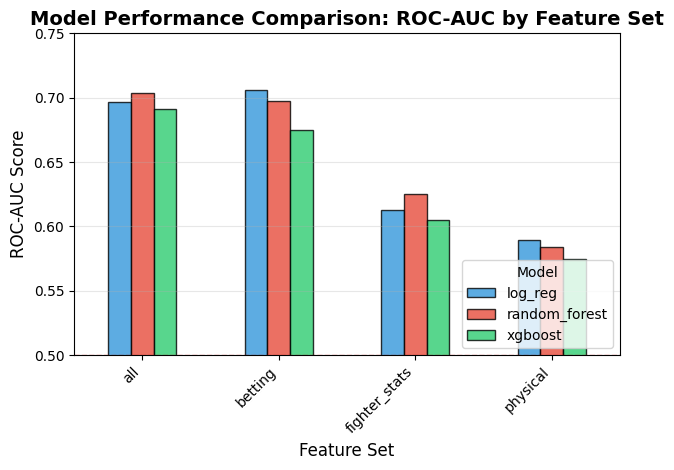

In [12]:
# Visualization 1: ROC-AUC Comparison by Feature Set
plt.figure(figsize=(12, 6))
pivot_roc = results_df.pivot(index='feature_set', columns='model', values='roc_auc')
pivot_roc.plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Feature Set', fontsize=12)
plt.title('Model Performance Comparison: ROC-AUC by Feature Set', fontsize=14, fontweight='bold')
plt.legend(title='Model', loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.5, 0.75)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Baseline')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

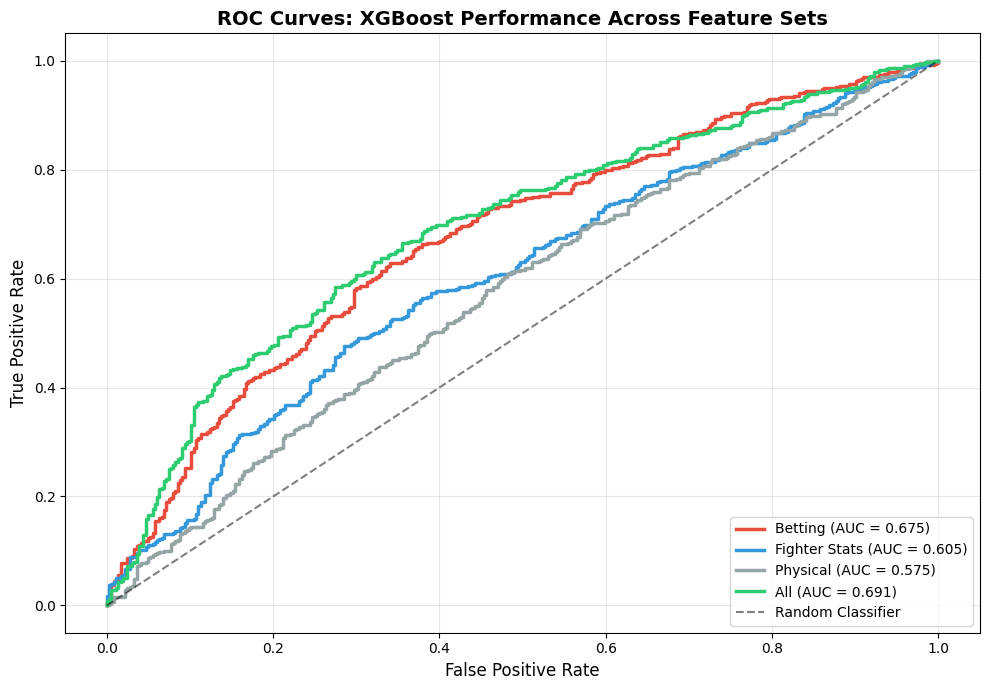

In [13]:
# Visualization 2: ROC Curves Across Feature Sets
plt.figure(figsize=(10, 7))
colors = {'betting': '#e74c3c', 'fighter_stats': '#3498db', 'physical': '#95a5a6', 'all': '#2ecc71'}
for feature_set, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], 
             label=f"{feature_set.replace('_', ' ').title()} (AUC = {data['auc']:.3f})",
             linewidth=2.5, color=colors[feature_set])
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: XGBoost Performance Across Feature Sets', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

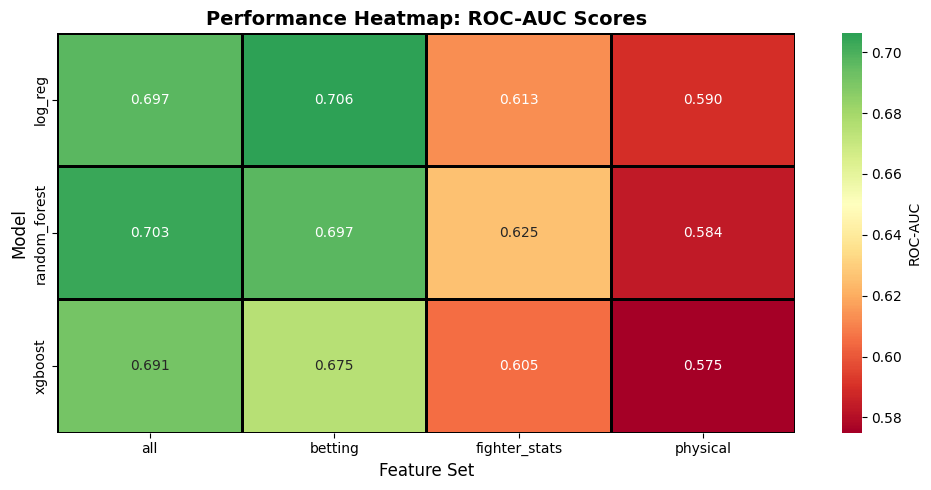

In [14]:
# Visualization 3: Performance Heatmap
plt.figure(figsize=(10, 5))
heatmap_data = results_df.pivot(index='model', columns='feature_set', values='roc_auc')
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0.65, 
            linewidths=1, linecolor='black', cbar_kws={'label': 'ROC-AUC'})
plt.title('Performance Heatmap: ROC-AUC Scores', fontsize=14, fontweight='bold')
plt.xlabel('Feature Set', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()